In [1]:
# Simplified imports for single GPU
from logging import getLogger
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from memory_layers import HashingMemory, MemoryLayerMonitorAndCheckpoint, load_and_process_dataset, ModelEvaluator, load_hellaswag_dataset

logger = getLogger()

/home/sagoyal/research/finetuningmemorylayers/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load Qwen0.5 Instruct
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct").to(device)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")

# Qwen0.5 specs: 896 hidden_dim, 24 layers
hidden_dim = 896
layers_to_replace = [6, 12, 18]  # Which FFN layers to replace

# Replace FFNs with Memory Layers
for layer_idx in layers_to_replace:
    layer = model.model.layers[layer_idx]
    
    # Create memory layer
    memory_layer = HashingMemory(
        input_dim=hidden_dim,
        output_dim=hidden_dim,
        mem_n_keys=128,          # Memory size = 512² = 262k entries
        mem_heads=4,
        mem_knn=16,
        mem_k_dim=256,
        mem_v_dim=-1,            # Auto: uses output_dim
        swilu_projection=True,
        value_fixed_lr=0.001,
        mem_share_values=False,  # Don't share across layers for fine-tuning
    )
    
    # Initialize the memory layer
    memory_layer.reset_parameters()
    # Ensure memory layer matches model dtype (float16)
    memory_layer.to(device)

    print(next(memory_layer.parameters()).dtype)
    # Replace the FFN (MLP) with memory layer
    original_mlp = layer.mlp
    layer.mlp = memory_layer
    
    print(f"Replaced layer {layer_idx} FFN with memory layer")


# Load weights

from safetensors.torch import load_file


try:
    state_dict = load_file("./qwen_memory_final/model.safetensors")
    print("Loaded from safetensors")
except:
    state_dict = torch.load("./qwen_memory_final/pytorch_model.bin", 
                           weights_only=False)

model.load_state_dict(state_dict, strict=False)
print("\n✅ Model loaded successfully!")

# FREEZE EVERYTHING EXCEPT MEMORY LAYERS
for name, param in model.named_parameters():
    if 'mlp' in name and any(f'layers.{idx}.' in name for idx in layers_to_replace):
        # This is a memory layer parameter - keep trainable
        param.requires_grad = True
        print(f"✓ Trainable: {name}")
    else:
        # Freeze all other parameters
        param.requires_grad = True

# Verify what's trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")

torch.float32
Replaced layer 6 FFN with memory layer
torch.float32
Replaced layer 12 FFN with memory layer
torch.float32
Replaced layer 18 FFN with memory layer
Loaded from safetensors

✅ Model loaded successfully!
✓ Trainable: model.layers.6.mlp.keys
✓ Trainable: model.layers.6.mlp.values.weight
✓ Trainable: model.layers.6.mlp.value_proj.weight
✓ Trainable: model.layers.6.mlp.value_proj.bias
✓ Trainable: model.layers.6.mlp.swilu_projection.weight
✓ Trainable: model.layers.6.mlp.swilu_projection.bias
✓ Trainable: model.layers.6.mlp.query_proj.query_mlps.0.weight
✓ Trainable: model.layers.6.mlp.query_proj.query_mlps.0.bias
✓ Trainable: model.layers.12.mlp.keys
✓ Trainable: model.layers.12.mlp.values.weight
✓ Trainable: model.layers.12.mlp.value_proj.weight
✓ Trainable: model.layers.12.mlp.value_proj.bias
✓ Trainable: model.layers.12.mlp.swilu_projection.weight
✓ Trainable: model.layers.12.mlp.swilu_projection.bias
✓ Trainable: model.layers.12.mlp.query_proj.query_mlps.0.weight
✓ Trainab

In [3]:
# Load and process dataset
finetune_dataset = load_and_process_dataset(tokenizer, sample_size=10000)

# Split into train and eval
# Use first 1000 for evaluation, rest for training
eval_dataset = finetune_dataset.select(range(1000))
train_dataset = finetune_dataset.select(range(1000, len(finetune_dataset)))

print(f"Training set size: {len(train_dataset)}")
print(f"Evaluation set size: {len(eval_dataset)}")

Filtered dataset size: 24406
Tokenized dataset: Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 10000
})
Training set size: 9000
Evaluation set size: 1000


In [4]:
# load hellaswag
sparse_finetune_dataset = load_hellaswag_dataset(tokenizer, sample_size = 1000)

# eval_sft = sparse_finetune_dataset.select(range(200))
# train_sft = sparse_finetune_dataset.select(range(200, len(sparse_finetune_dataset)))


HellaSwag tokenized dataset: Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1000
})


In [5]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)


In [7]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from memory_layers import ModelEvaluator

# Training arguments optimized for memory layers only
training_args = TrainingArguments(
    output_dir="./qwen_memory_finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=5e-4,  # Higher LR since only training memory
    warmup_steps=100,
    lr_scheduler_type="cosine",
    logging_steps=10,
    logging_first_step=True,  # Log immediately
    logging_dir="./logs",
    save_steps=500,
    eval_strategy="steps",
    eval_steps=25,   
    # Performance
    fp16=True,
    gradient_checkpointing=False,  # Not needed with frozen base
    dataloader_num_workers=2,
    
    # Monitoring
    report_to="wandb",  # or "wandb" if you have it
    # load_best_model_at_end=True,
    metric_for_best_model="loss",
    save_strategy="no",
    
    # Memory optimization
    optim="adamw_torch_fused",  # Faster optimizer
    max_grad_norm=1.0,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Initialize Evaluator
# evaluator = ModelEvaluator(model, tokenizer, device=device)
from memory_layers.ft_callbacks import FinetuneMonitorAndCheckpoint

# Initialize callback
memory_monitor = FinetuneMonitorAndCheckpoint(
    model=model,
    layers_to_check=layers_to_replace,
    save_every=500,
    keep_last=2,
    monitor_every=500,
    # evaluator=evaluator,
    # eval_every=50,     # Run evaluation every 100 steps
    # eval_samples=50     # Small sample size for speed during training
)

# Create trainer with callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=sparse_finetune_dataset,
    eval_dataset=sparse_finetune_dataset,
    data_collator=data_collator,
    callbacks=[memory_monitor],  # Add our custom monitor
)

print("\n✅ SparseMemoryTrainer is set up. trainer.train() cell will now do sparse memory finetuning.")
print(f"Total steps: {len(sparse_finetune_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



✅ SparseMemoryTrainer is set up. trainer.train() cell will now do sparse memory finetuning.
Total steps: 186


In [8]:
print("\n🚀 Starting training...")

# Train!
trainer.train()

print("\n✅ Training complete!")

wandb: Currently logged in as: sagoyal (sagoyal-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



🚀 Starting training...


Step,Training Loss,Validation Loss
25,3.202900,2.843996
50,3.701600,2.982192
75,3.111200,2.713466
100,3.347000,2.749507
125,3.414200,2.233509
150,2.077000,1.644853
175,1.841000,1.025791



🏁 TRAINING COMPLETE - Saving final model

✅ Final model saved to: ./qwen_memory_ft
   Total steps: 189
   Total epochs: 3.00
   Loss improvement: 2.1014



✅ Training complete!


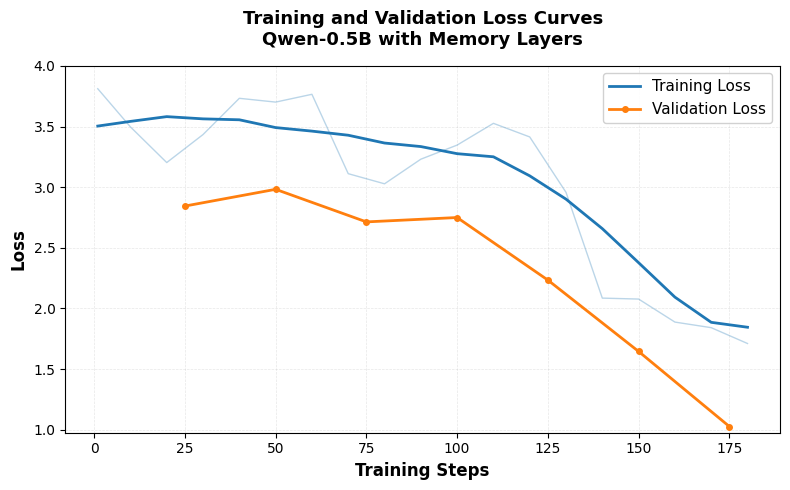

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Extract training and evaluation losses
log_history = trainer.state.log_history
train_losses = [(log['step'], log['loss']) for log in log_history if 'loss' in log]
eval_losses = [(log['step'], log['eval_loss']) for log in log_history if 'eval_loss' in log]

# Unpack into separate lists
train_steps, train_loss_values = zip(*train_losses) if train_losses else ([], [])
eval_steps, eval_loss_values = zip(*eval_losses) if eval_losses else ([], [])

# Create figure with appropriate size for papers (IEEE standard: 3.5" or 7" width)
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# Plot training loss (with optional smoothing for cleaner visualization)
if train_steps:
    ax.plot(train_steps, train_loss_values, alpha=0.3, color='#1f77b4', linewidth=1)

    # Add smoothed line if enough data points
    if len(train_loss_values) > 10:
        window_size = min(11, len(train_loss_values) // 3)
        smoothed_loss = uniform_filter1d(train_loss_values, size=window_size)
        ax.plot(train_steps, smoothed_loss, label='Training Loss',
                color='#1f77b4', linewidth=2)
    else:
        ax.plot(train_steps, train_loss_values, label='Training Loss',
                color='#1f77b4', linewidth=2)

# Plot evaluation loss
if eval_steps:
    ax.plot(eval_steps, eval_loss_values, label='Validation Loss',
            color='#ff7f0e', linewidth=2, marker='o', markersize=4)

# Formatting
ax.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training and Validation Loss Curves\nQwen-0.5B with Memory Layers',
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

# Set y-axis to start from a reasonable minimum
if train_loss_values or eval_loss_values:
    all_losses = list(train_loss_values) + list(eval_loss_values)
    y_min = min(all_losses) * 0.95
    y_max = max(all_losses) * 1.05
    ax.set_ylim(y_min, y_max)

# Tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Optionally save as high-quality figure for paper
# fig.savefig('loss_curve.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('loss_curve.png', dpi=300, bbox_inches='tight')


In [12]:
import json


log_history = trainer.state.log_history
train_losses = [(log['step'], log['loss']) for log in log_history if 'loss' in log]
eval_losses = [(log['step'], log['eval_loss']) for log in log_history if 'eval_loss' in log]

# Unpack into separate lists
train_steps, train_loss_values = zip(*train_losses) if train_losses else ([], [])
eval_steps, eval_loss_values = zip(*eval_losses) if eval_losses else ([], [])

# Or save just the processed data
training_data = {
    'train_losses': train_losses,
    'eval_losses': eval_losses
}
with open('losses.json', 'w') as f:
    json.dump(training_data, f, indent=2)


import pandas as pd

df = pd.DataFrame({
    'train_steps': train_steps,
    'train_loss': train_loss_values
})
df.to_csv('full_finetuning_train_losses.csv', index=False)

df_eval = pd.DataFrame({
    'eval_steps': eval_steps, 
    'eval_loss': eval_loss_values
})
df_eval.to_csv('full_finetuning_eval_losses.csv', index=False)

In [ ]:
from safetensors.torch import load_file

device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_dim = 896
layers_to_replace = [6, 12, 18]

# Reload model for testing
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
    dtype=torch.float16,
).to(device)

# Add memory layers
for idx in layers_to_replace:
    # Initialize and cast to correct device/dtype
    mem_layer = HashingMemory(
        input_dim=hidden_dim, output_dim=hidden_dim, mem_n_keys=128, mem_heads=4,
        mem_knn=16, mem_k_dim=256, mem_v_dim=-1, swilu_projection=True,
        value_fixed_lr=0.001, mem_share_values=False
    )
    # Important: Cast to model's dtype (float16) to avoid "Half and Float" errors
    model.model.layers[idx].mlp = mem_layer.to(device, dtype=model.dtype)

# Load weights
try:
    state_dict = load_file("./qwen_memory_final/model.safetensors")
except:
    state_dict = torch.load("./qwen_memory_final/pytorch_model.bin",
                           weights_only=False)

model.load_state_dict(state_dict, strict=False)
print("\n✅ Model loaded successfully!")

# Test generation
def test_model(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Try some prompts
test_prompts = [
    "Explain quantum computing in simple terms:",
    "Write a Python function to sort a list:",
    "What are the health benefits of exercise?",
]

for prompt in test_prompts:
    print(f"\n{'='*80}")
    print(f"Prompt: {prompt}")
    print(f"{'='*80}")
    response = test_model(prompt)
    print(response)

In [ ]:
# Load original Qwen model for comparison
base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
    torch_dtype=torch.float16,
)
base_model.to(device)

def compare_models(prompt):
    # Your fine-tuned model
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        # Fine-tuned
        ft_outputs = model.generate(**inputs, max_new_tokens=100)
        ft_response = tokenizer.decode(ft_outputs[0], skip_special_tokens=True)

        # Base
        base_outputs = base_model.generate(**inputs, max_new_tokens=100)
        base_response = tokenizer.decode(base_outputs[0], skip_special_tokens=True)

    print(f"\n{'='*80}")
    print(f"Prompt: {prompt}")
    print(f"{'='*80}")
    print(f"\n🔷 BASE MODEL:")
    print(base_response)
    print(f"\n🔶 FINE-TUNED (with memory layers):")
    print(ft_response)
    print(f"{'='*80}\n")

# Test
compare_models("Explain machine learning:")